In [1]:
%config IPCompleter.greedy = True

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import os
import datetime
import random as rn

import cv2

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
# np.random.seed(50)
# rn.seed(30)

import tensorflow as tf
tf.set_random_seed(30)

### 1. Load Dataset
***

In [5]:
train_path = 'data/train/'
val_path = 'data/val/'

train_doc = np.random.permutation(open('data/train.csv').readlines())
val_doc = np.random.permutation(open('data/val.csv').readlines())

In [6]:
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

print('total number of training sequences - {0}'.format(num_train_sequences))
print('total number of validation sequences - {0}'.format(num_val_sequences))

total number of training sequences - 663
total number of validation sequences - 100


### 2. Helper Functions
***

#### Display images in subplots

In [7]:
def plot_image(images, cmap=None):
    total_images = len(images)
    rows = 0

    if total_images < 6:
        rows = 1
    elif total_images % 5 == 0:
        rows = total_images / 5
    else:
        rows = (total_images // 5) + 1

    f, axes = plt.subplots(int(rows),
                           (5 if total_images > 5 else total_images),
                           sharex=True,
                           sharey=True)
    f.set_figwidth(15)
    f.set_figheight(5)
    row_elements = 5

    if rows == 1:
        for ax, image in zip(axes, images):
            ax.imshow(image, cmap)
    else:
        for i, row_ax in enumerate(axes):
            start_index = i * row_elements

            for ax, image in zip(row_ax, images[start_index:start_index + 5]):
                ax.imshow(image, cmap)

#### display images from randomly selected folders

shape of an image in the selected sequence : (120, 160, 3)


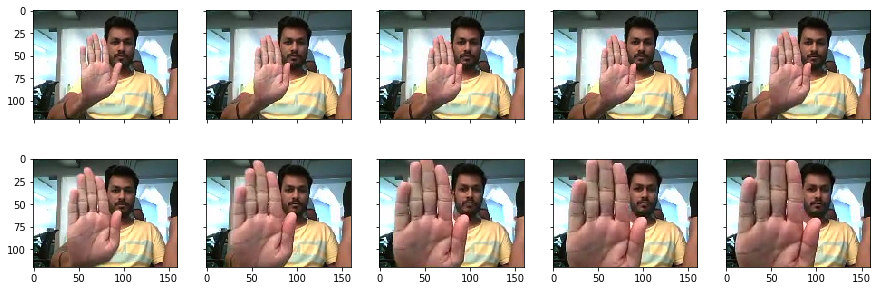

In [8]:
random_train_index = rn.randint(0, len(train_doc))

sequence_dir = train_doc[random_train_index].split(';')[0]

# list of all images in the folder
image_names = os.listdir(train_path + sequence_dir)

images = []
for name in image_names[0:30:3]:
    img = cv2.imread(train_path + sequence_dir + '/' + name)
    images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

print('shape of an image in the selected sequence : {0}'.format(images[0].shape))    
    
plot_image(images)

### 2. Image Preprocessor
***

In [9]:
class ImagePreprocessor:
    def __init__(self,
                 height=120,
                 width=120,
                 channel=3,
                 affine=False,
                 crop=False,
                 edge=False,
                 normalize=False,
                 resize=False,
                 smoothing=False):
        self.__height = height
        self.__width = width
        self.__channel = channel
        self._affine = affine
        self._crop = crop
        self._edge = edge
        self._normalize = normalize
        self._resize = resize
        self._smoothing = smoothing

    def process_image(self, orig_image):
        pr_image = orig_image

        if self._crop:
            pr_image = self.__crop(pr_image)

        if self._resize:
            pr_image = self.__resize(pr_image)

        if self._normalize:
            pr_image = self.__normalize(pr_image)

        if self._smoothing:
            pr_image = self.__smoothing(pr_image)

        if self._edge:
            pr_image = self.__edge_detection(pr_image)

        return pr_image

    def __crop(self, image):
        i_shape = image.shape
        return image[20:i_shape[0], 0:i_shape[1]]

    def __normalize(self, image):
        n_image = np.zeros((self.__height, self.__width, self.__channel))
        n_image = cv2.normalize(image, n_image, 0, 255, cv2.NORM_MINMAX)

        return n_image

    def __resize(self, image):
        return cv2.resize(image, (self.__height, self.__width),
                          interpolation=cv2.INTER_AREA)

    def __smoothing(self, image):
        return cv2.GaussianBlur(image, (5, 5), cv2.BORDER_DEFAULT)

    def __edge_detection(self, image):
        return cv2.Canny(image, 100, 150)

preprocess images displayed earlier

shape of an image in the selected sequence : (120, 120, 3)


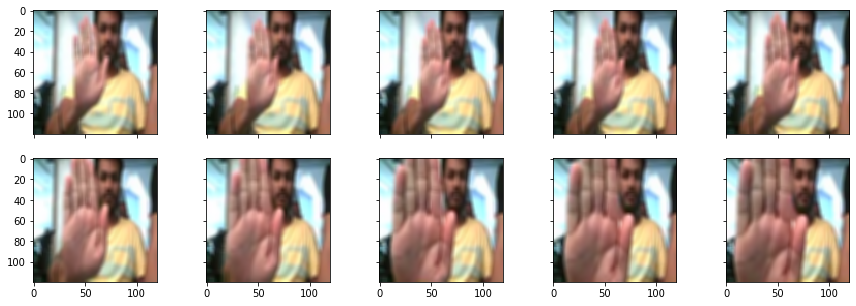

In [10]:
imagePreprocess = ImagePreprocessor(crop=True, normalize=True, resize=True, smoothing=True)

pr_images = []

for name in image_names[0:30:3]:
    img = cv2.imread(train_path + sequence_dir + '/' + name)
    pr_image = imagePreprocess.process_image(orig_image=img)
    pr_images.append(cv2.cvtColor(pr_image, cv2.COLOR_BGR2RGB))

print('shape of an image in the selected sequence : {0}'.format(pr_images[0].shape))    
    
plot_image(pr_images)

preprocess images with edge detection = True and smoothing = False

** Canny algorithm performs a Gaussian smoothing before applying edge detection algorithm. Hence no need for an additional smoothing.

shape of an image in the selected sequence : (120, 120, 3)


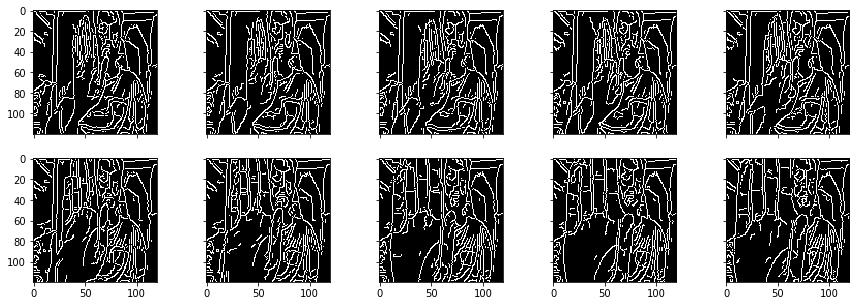

In [11]:
imagePreprocess = ImagePreprocessor(crop=True, normalize=True, resize=True, smoothing=False, edge=True)

pr_images = []

for name in image_names[0:30:3]:
    img = cv2.imread(train_path + sequence_dir + '/' + name)
    pr_image = imagePreprocess.process_image(orig_image=img)
    pr_images.append(cv2.cvtColor(pr_image, cv2.COLOR_BGR2RGB))

print('shape of an image in the selected sequence : {0}'.format(pr_images[0].shape))    
    
plot_image(pr_images)

### 3. Parameter Initialization
***

In [12]:
class ModelParameters:
    def __init__(self,
                 im_height=120,
                 im_width=120,
                 filters=[8, 16, 32, 64],
                 dense=[5000, 500, 5],
                 epochs=20,
                 batch_size=10,
                 lrate=0.001):
        self.__height = im_height
        self.__width = im_width
        self.__channels = 3

        self.FrameIndexes = 'ALL'
        self.Filters = filters
        self.DenseLayers = dense

        self.Epochs = epochs
        self.BatchSize = batch_size
        self.LRate = lrate

    @property
    def Filters(self):
        return self.__filters

    @Filters.setter
    def Filters(self, val):
        self.__filters = val

    @property
    def DenseLayers(self):
        return self.__dense

    @DenseLayers.setter
    def DenseLayers(self, val):
        self.__dense = val

    @property
    def FrameIndexes(self):
        return self.__frames

    @FrameIndexes.setter
    def FrameIndexes(self, val):
        if val == 'ALL':
            self.__frames = [x for x in range(0, 30)]
        else:
            self.__frames = [x for x in range(0, 30, 3)]
            self.__frames.append(30)

    @property
    def Epochs(self):
        return self.__epochs

    @Epochs.setter
    def Epochs(self, val):
        self.__epochs = val

    @property
    def BatchSize(self):
        return self.__bsize

    @BatchSize.setter
    def BatchSize(self, val):
        self.__bsize = val

    @property
    def LRate(self):
        return self.__lrate

    @LRate.setter
    def LRate(self, val):
        self.__lrate = val

    def set_image_dimensions(self, height, width):
        self.__height = height
        self.__width = width

    def input_shape(self):
        return (len(self.FrameIndexes), self.__height, self.__width, self.__channels)

    def optimizer(self, optimizers, otype='SGD'):
        if otype == 'ADAM':
            return optimizers.Adam(self.LRate)
        else:
            return optimizers.SGD(lr=self.LRate, momentum=0.9, nesterov=True)

    def steps_per_epoch(self, num_train_sequences):
        if (num_train_sequences % self.BatchSize) == 0:
            return int(num_train_sequences / self.BatchSize)
        else:
            return (num_train_sequences // self.BatchSize) + 1

    def validation_steps(self, num_val_sequences):
        if (num_val_sequences % self.BatchSize) == 0:
            return int(num_val_sequences / self.BatchSize)
        else:
            return (num_val_sequences // self.BatchSize) + 1

### 4. Data Generator
***

In [13]:
def generator(source_path, folder_list, ipreprocessor, mparameters):

    img_idx = mparameters.FrameIndexes
    input_shape = mparameters.input_shape()
    batch_size = mparameters.BatchSize
    
    while True:
        # shuffle the array of video sequences prior to creating individual batches
        t = np.random.permutation(folder_list)

        num_batches = len(t) // batch_size

        for batch in range(num_batches):

            # x is the number of images you use for each video,
            # (y,z) is the final size of the input images
            # 3 is the number of channels RGB
            batch_data = np.zeros((batch_size, len(img_idx), input_shape[1],
                                   input_shape[2], input_shape[3]))
            
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):

                fl_index = folder + (batch * batch_size)
                fl_name = t[fl_index].strip().split(';')[0]

                # read all the images in the folder
                imgs = os.listdir(source_path + '/' + fl_name)

                # iterate iver the frames/images of a folder to read them in
                for idx, item in enumerate(img_idx):

                    image = cv2.imread(source_path + '/' + fl_name + '/' + imgs[item])

                    pr_image = ipreprocessor.process_image(orig_image=image)
                    
                    batch_data[folder, idx, :, :, 0] = pr_image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = pr_image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = pr_image[:, :, 2]

                batch_labels[folder, int(t[fl_index].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):

            batch_size = len(folder_list) - (batch_size * num_batches)
            batch_data = np.zeros(
                (batch_size, len(img_idx), im_height, im_width, im_channels))
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):

                fl_index = folder + (batch * batch_size)
                fl_name = t[fl_index].strip().split(';')[0]

                # read all the images in the folder
                imgs = os.listdir(source_path + '/' + fl_name)

                for idx, item in enumerate(img_idx):

                    image = cv2.imread(source_path + '/' + fl_name + '/' + imgs[item])

                    pr_image = ipreprocessor.process_image(orig_image=image)

                    batch_data[folder, idx, :, :, 0] = pr_image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = pr_image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = pr_image[:, :, 2]

                batch_labels[folder, int(t[fl_index].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

### <font color='#3F51B5'>5. Models</font>
***

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

Using TensorFlow backend.


In [15]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

In [16]:
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=False,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.5,
                       patience=2,
                       cooldown=1,
                       verbose=1)

callbacks_list = [checkpoint, LR]

### <font color='#bb9d53'>Model #1</font>
*****

In [17]:
def con3d_default_model(input_shape, nb_filters, nb_dense):

    model_a = Sequential()

    # layer 1
    model_a.add(
        Conv3D(nb_filters[0],
               kernel_size=(3, 3, 3),
               input_shape=input_shape,
               padding='same'))
    model_a.add(BatchNormalization())
    model_a.add(Activation('relu'))

    model_a.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # layer 2
    model_a.add(Conv3D(nb_filters[1], kernel_size=(3, 3, 3), padding='same'))
    model_a.add(BatchNormalization())
    model_a.add(Activation('relu'))

    model_a.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # layer 3
    model_a.add(Conv3D(nb_filters[2], kernel_size=(1, 3, 3), padding='same'))
    model_a.add(BatchNormalization())
    model_a.add(Activation('relu'))

    model_a.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # layer 4
    model_a.add(Conv3D(nb_filters[3], kernel_size=(1, 3, 3), padding='same'))
    model_a.add(BatchNormalization())
    model_a.add(Activation('relu'))

    model_a.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Flatten Layers
    model_a.add(Flatten())

    # dense layer 1
    model_a.add(Dense(nb_dense[0], activation='relu'))
    model_a.add(Dropout(rate=0.5))

    # dense layer 2
    model_a.add(Dense(nb_dense[1], activation='relu'))
    model_a.add(Dropout(rate=0.5))

    #softmax layer
    model_a.add(Dense(nb_dense[2], activation='softmax'))

    return model_a

#### <font color='#bb9d53'>Model Parameters</font>
***

In [18]:
imagePreprocessor = ImagePreprocessor(crop=True,
                                      normalize=True,
                                      resize=True,
                                      smoothing=True)

modelParameters = ModelParameters()

train_generator = generator(train_path, train_doc, imagePreprocessor, modelParameters)
val_generator = generator(val_path, val_doc, imagePreprocessor, modelParameters)

#### <font color='#bb9d53'>Model Summary</font>
***

In [19]:
model_a = con3d_default_model(modelParameters.input_shape(),
                            modelParameters.Filters,
                            modelParameters.DenseLayers)

model_a.compile(optimizer=modelParameters.optimizer(optimizers),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

print(model_a.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________

#### <font color='#bb9d53'>Train Model</font>
***

In [20]:
model_a.fit_generator(train_generator,
                      steps_per_epoch=modelParameters.steps_per_epoch(num_train_sequences),
                      epochs=modelParameters.Epochs,
                      verbose=1,
                      callbacks=callbacks_list,
                      validation_data=val_generator,
                      validation_steps=modelParameters.validation_steps(num_val_sequences),
                      class_weight=None,
                      workers=1,
                      initial_epoch=0)